In [61]:
import re
from matplotlib import pyplot as plt
import pickle
import tensorflow_datasets as tfds
import nltk
from sentence_transformers import SentenceTransformer, util
import numpy as np
from LexRank import degree_centrality_scores
from oracle_generator import nallapati_method
import tensorflow as tf
nltk.download('punkt')
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[nltk_data] Downloading package punkt to
[nltk_data]     /home/g/gwtaylor/schnei/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [31]:
cache = "../data"
scientific_papers, info = tfds.load('scientific_papers/pubmed', split = "train", shuffle_files = False, 
                              data_dir = "/scratch/g/gwtaylor/schnei/data/alex/tensorflow_datasets", with_info=True)
#scientific_papers = load_dataset('scientific_papers', 'pubmed', cache_dir=cache)
"""cache = "mnt/MyDrive/nlp/data/scientific_papers/pubmed/1.1.1/b941f4678d5bed229aca0ab5b4cc943dadf74a8ab153178487bdf51810dc4f67"
scientific_papers = load_from_disk(cache)"""

INFO:absl:Load dataset info from /scratch/g/gwtaylor/schnei/data/alex/tensorflow_datasets/scientific_papers/pubmed/1.1.1
INFO:absl:Reusing dataset scientific_papers (/scratch/g/gwtaylor/schnei/data/alex/tensorflow_datasets/scientific_papers/pubmed/1.1.1)
INFO:absl:Constructing tf.data.Dataset for split train, from /scratch/g/gwtaylor/schnei/data/alex/tensorflow_datasets/scientific_papers/pubmed/1.1.1


'cache = "mnt/MyDrive/nlp/data/scientific_papers/pubmed/1.1.1/b941f4678d5bed229aca0ab5b4cc943dadf74a8ab153178487bdf51810dc4f67"\nscientific_papers = load_from_disk(cache)'

In [53]:
thing = scientific_papers.take(1)

# To-Do
- read emnlp paper [done]
- read up on lexrank [done]
- find and download xsum dataset [done]
- try lexrank on some sentences in xsum dataset [done]
- read up on sentence transformers [done]
- figure out how people trained xsum models. [done]
- train encoder-decoder transformer on xsum 

# Stuff I did
- Data Preprocessing
    - replaced `\n` with space character (` `)
    - removed all duplicate sentences
    - removed 178 examples larger than 100000 chars and 4746 examples shorter than 2500 chars for a total of 4924 examples from the training set. This is roughly 5% of it. This is just a heuristic. This removal will be applied using `omit`

In [69]:
"""
This example uses LexRank (https://www.aaai.org/Papers/JAIR/Vol22/JAIR-2214.pdf)
to create an extractive summarization of a long document.
The document is splitted into sentences using NLTK, then the sentence embeddings are computed. We
then compute the cosine-similarity across all possible sentence pairs.
We then use LexRank to find the most central sentences in the document, which form our summary.
Input document: First section from the English Wikipedia Section
Output summary:
Located at the southern tip of the U.S. state of New York, the city is the center of the New York metropolitan area, the largest metropolitan area in the world by urban landmass.
New York City (NYC), often called simply New York, is the most populous city in the United States.
Anchored by Wall Street in the Financial District of Lower Manhattan, New York City has been called both the world's leading financial center and the most financially powerful city in the world, and is home to the world's two largest stock exchanges by total market capitalization, the New York Stock Exchange and NASDAQ.
New York City has been described as the cultural, financial, and media capital of the world, significantly influencing commerce, entertainment, research, technology, education, politics, tourism, art, fashion, and sports.
If the New York metropolitan area were a sovereign state, it would have the eighth-largest economy in the world.
"""



model = SentenceTransformer('msmarco-distilroberta-base-v2')

# Our input document we want to summarize
# As example, we take the first section from Wikipedia
document = str([ex for ex in thing][0]['article']).replace("\\n", ' ')

"""
New York City (NYC), often called simply New York, is the most populous city in the United States. With an estimated 2019 population of 8,336,817 distributed over about 302.6 square miles (784 km2), New York City is also the most densely populated major city in the United States. Located at the southern tip of the U.S. state of New York, the city is the center of the New York metropolitan area, the largest metropolitan area in the world by urban landmass. With almost 20 million people in its metropolitan statistical area and approximately 23 million in its combined statistical area, it is one of the world's most populous megacities. New York City has been described as the cultural, financial, and media capital of the world, significantly influencing commerce, entertainment, research, technology, education, politics, tourism, art, fashion, and sports. Home to the headquarters of the United Nations, New York is an important center for international diplomacy.
Situated on one of the world's largest natural harbors, New York City is composed of five boroughs, each of which is a county of the State of New York. The five boroughs—Brooklyn, Queens, Manhattan, the Bronx, and Staten Island—were consolidated into a single city in 1898. The city and its metropolitan area constitute the premier gateway for legal immigration to the United States. As many as 800 languages are spoken in New York, making it the most linguistically diverse city in the world. New York is home to more than 3.2 million residents born outside the United States, the largest foreign-born population of any city in the world as of 2016. As of 2019, the New York metropolitan area is estimated to produce a gross metropolitan product (GMP) of $2.0 trillion. If the New York metropolitan area were a sovereign state, it would have the eighth-largest economy in the world. New York is home to the highest number of billionaires of any city in the world.
New York City traces its origins to a trading post founded by colonists from the Dutch Republic in 1624 on Lower Manhattan; the post was named New Amsterdam in 1626. The city and its surroundings came under English control in 1664 and were renamed New York after King Charles II of England granted the lands to his brother, the Duke of York. The city was regained by the Dutch in July 1673 and was subsequently renamed New Orange for one year and three months; the city has been continuously named New York since November 1674. New York City was the capital of the United States from 1785 until 1790, and has been the largest U.S. city since 1790. The Statue of Liberty greeted millions of immigrants as they came to the U.S. by ship in the late 19th and early 20th centuries, and is a symbol of the U.S. and its ideals of liberty and peace. In the 21st century, New York has emerged as a global node of creativity, entrepreneurship, and environmental sustainability, and as a symbol of freedom and cultural diversity. In 2019, New York was voted the greatest city in the world per a survey of over 30,000 people from 48 cities worldwide, citing its cultural diversity.
Many districts and landmarks in New York City are well known, including three of the world's ten most visited tourist attractions in 2013. A record 62.8 million tourists visited New York City in 2017. Times Square is the brightly illuminated hub of the Broadway Theater District, one of the world's busiest pedestrian intersections, and a major center of the world's entertainment industry. Many of the city's landmarks, skyscrapers, and parks are known around the world. Manhattan's real estate market is among the most expensive in the world. Providing continuous 24/7 service and contributing to the nickname The City that Never Sleeps, the New York City Subway is the largest single-operator rapid transit system worldwide, with 472 rail stations. The city has over 120 colleges and universities, including Columbia University, New York University, Rockefeller University, and the City University of New York system, which is the largest urban public university system in the United States. Anchored by Wall Street in the Financial District of Lower Manhattan, New York City has been called both the world's leading financial center and the most financially powerful city in the world, and is home to the world's two largest stock exchanges by total market capitalization, the New York Stock Exchange and NASDAQ.
"""

#Split the document into sentences
sentences = list(set(nltk.sent_tokenize(document)))
print("Num sentences:", len(sentences))

#Compute the sentence embeddings
embeddings = model.encode(sentences, convert_to_tensor=True)

#Compute the pair-wise cosine similarities
cos_scores = util.pytorch_cos_sim(embeddings, embeddings).numpy()

#Compute the centrality for each sentence
centrality_scores = degree_centrality_scores(cos_scores, threshold=None)

#We argsort so that the first element is the sentence with the highest score
most_central_sentence_indices = np.argsort(-centrality_scores)


#Print the 5 sentences with the highest scores
print("\n\nSummary:")
for idx in most_central_sentence_indices[0:5]:
    print(sentences[idx].strip())

Num sentences: 52


Summary:
most reported cases show that avms located in the ipsilateral side of moyamoya vessels are associated with a moyamoya - type collateral.6 - 16 one hypothesis is that vascular occlusion drives from acquired dysplasia as a consequence of high blood flow from the avm .
we report herein a case of avm with a feeding arterial occlusion and unilateral moyamoya disease coexisting in an acute stroke patient .
the incidence of avm is below 1 : 100,000 and accounts for about 1 - 2% of all strokes , and 3% of those in young patients.1 although the association between avms and aneurysms is well known , an avm in combination with moyamoya disease or progressive arterial occlusion has been reported only rarely.2 avms are generally thought to be congenital vascular anomalies that arise as a result of the abnormal development of blood vessels during the early embryonic period.3 conversely , moyamoya disease is a progressive vascular disease that is defined as bilateral dist

In [71]:
str([ex for ex in thing][0]['abstract']).replace("\\n", ' ')

"tf.Tensor(b' backgroundarteriovenous malformations ( avms ) with vascular abnormalities , including aneurysms , have been reported frequently . however , the coexistence of avm and unilateral moyamoya disease is rare .   we report herein an avm patient who presented with acute ischemic stroke with unilateral moyamoya disease and occlusion of the feeding artery.case reporta-41-year old man was admitted with sudden dysarthria and facial palsy .   brain computed tomography and magnetic resonance imaging revealed an acute infarction adjacent to a large avm in the right frontal lobe .   cerebral angiography revealed occlusions of the proximal right middle cerebral and proximal anterior cerebral arteries , which were the main feeders of the avm .   innumerable telangiectatic moyamoya - type vessels between branches of the anterior cerebral artery and dilated lenticulostriate arteries on the occluded middle cerebral artery were detected .   however , a nidus of the avm was still opacified th

In [66]:
tf.strings("asda")

TypeError: 'module' object is not callable

In [72]:
test = ['as clinical manifestation of pulmonary tuberculosis and nocardiosis are similar , laboratory tests are required in order to distinguish of nocardiosis from tuberculosis',
       'due to the fact that clinical manifestation of pulmonary tuberculosis and nocardiosis are similar , we should use laboratory test to differentiate nocardiosis from tuberculosis']
embeddings = model.encode(test, convert_to_tensor = True)
cos_scores = util.pytorch_cos_sim(embeddings, embeddings).numpy()

In [73]:
cos_scores

array([[1.0000001 , 0.9681876 ],
       [0.9681876 , 0.99999964]], dtype=float32)

In [11]:
scientific_papers['train'][200]['abstract'].replace('\n', ' ')

' background : tuberculosis ( tb ) remains as one of the most serious infectious diseases in the world .   pulmonary tuberculosis can occur with other pulmonary diseases caused by opportunistic organisms such as nocardia spp . particularly in immunocompromised patients .   therefore , diagnosis of co - infection at the early stage of the disease could be lifesaving.objectives:the goal of this study was to detect mycobacterium tuberculosis and nocardia spp . in sputum specimens in order to assess the concomitant nocardiosis and tuberculosis in patients with suspected pulmonary tuberculosis.patients and methods : from march 2011 to april 2012 , 189 sputum specimens were obtained from patients who were suspected of having pulmonary tuberculosis .   out of 189 samples , 32 of the samples belonged to hospitalized hiv - infected patients .   samples were examined by gram and ziehl - nelsen staining , culture and pcr methods.results:from 157 sputum specimens , positive samples by acid fast st

In [ ]:
most_central_sentence_indices

array([ 65,  74,  92,  69,  78,  79,  91,  87,  73,  64,  19,  94,  11,
       101,  58,  39,  83,  89, 108,  82,   6,  67,  76,  61,  70, 109,
        98,  60,  41,  15,  80,  21, 107,   3,  71,  62,  96,  99,  14,
        22,  55,  36,  12,  88,  85,  93,  17,  25,  44,   0,  38,  57,
       103,  84,  31,  50,  90,  20,  10, 104,  63,  72,  66,  75,  13,
        29,  48, 106,  28,  47,  97,  86,   1,   9,  40,  59,   7,  16,
         5,  18,  54,  35, 110,   8,   4,  24,  43,  56,  37,  27,  46,
        33,  52,  51,  32,  34,  53, 100,  30,  49,  81,  23,  42,  26,
        45,  77,  68,   2, 105,  95, 102], dtype=int64)

In [ ]:
sentences

['tuberculosis ( tb ) is caused by the mycobacterium tuberculosis , a member of the m. tuberculosis complex ( mtbc ) .',
 'according to the world health organization ( who ) , in 2010 , there were an estimated 12.0 million prevalent cases of tb ( equivalent to 178 cases per 100000 individuals ) and approximately 1.4 million people died of tb during that year .',
 'most of the cases in 2009 ( 55% ) occurred in asia ( 1 ) .',
 'according to the  administration of tuberculosis and leprosy control  of the ministry of health and medical education in iran , in 2010 , a total of 10485 old and new cases of tb were reported in iran and of these cases , 326 patients ( around 2.2% ) were hiv positive ( 2 ) .',
 'the diseases caused by mycobacterium complex have become more important in the recent years , particularly in association with the worldwide pandemic situation caused by human immunodeficiency virus ( hiv ) .',
 'in 2010 , in addition , there were an estimated 0.35 million deaths among tb

In [ ]:
scientific_papers['train'][200]['article'].replace('\n', ' ')

'tuberculosis ( tb ) is caused by the mycobacterium tuberculosis , a member of the m. tuberculosis complex ( mtbc ) . according to the world health organization ( who ) , in 2010 , there were an estimated 12.0 million prevalent cases of tb ( equivalent to 178 cases per 100000 individuals ) and approximately 1.4 million people died of tb during that year . most of the cases in 2009 ( 55% ) occurred in asia ( 1 ) . according to the  administration of tuberculosis and leprosy control  of the ministry of health and medical education in iran , in 2010 , a total of 10485 old and new cases of tb were reported in iran and of these cases , 326 patients ( around 2.2% ) were hiv positive ( 2 ) . the diseases caused by mycobacterium complex have become more important in the recent years , particularly in association with the worldwide pandemic situation caused by human immunodeficiency virus ( hiv ) . in 2010 , in addition , there were an estimated 0.35 million deaths among tb cases that were hiv 

In [ ]:
print(len(toobig))
print(len(toosmall))

2625
4746


# Visualizing Dataset

In [ ]:
import math 
mini = math.inf
maxi = 0
running = 0
dist = []
toobig = []
toosmall = []
for i, each in enumerate(scientific_papers['train']):
    length = len(each['article'])
    if mini > length:
        mini = length
    elif maxi < length:
        maxi = length
    running += length
    if length > 200000:
        toobig.append((i, length))
    elif length < 2500:
        toosmall.append((i, length))
    dist.append(length)
print(mini)
print(maxi)
print(running/len(scientific_papers['train']))

0
822179
17414.136077849304


In [ ]:
print(len(toobig))
print(len(toosmall))

178
4746


lets first visualize the distirbution of the lengths of the documents in the dataset

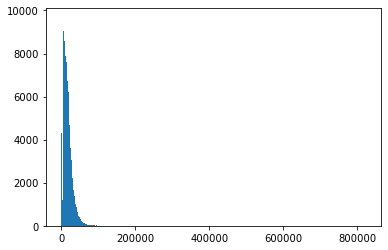

In [ ]:
n_bins = 500
#subdist = [each for each in dist if (each < 50000) and (each > 5000)]
x = dist
fig, ax = plt.subplots()
ax.hist(x, bins=n_bins)
plt.show()

Let's get a sense of how many extremely long documents we have

In [ ]:
toobigdist = []
for each in toobig:
    if each[1] > 100000:
        toobigdist.append(each[1])

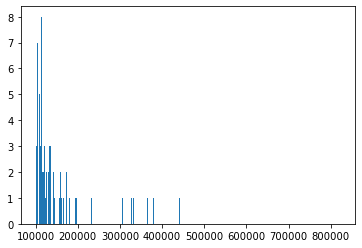

In [ ]:
n_bins = 1000
x = toobigdist
fig, ax = plt.subplots()
ax.hist(x, bins=n_bins)
plt.show()

Now let's get a sense of how many extermely short documents we have (< 2000 characters or roughly 400 words)

In [ ]:
toosmalldist = []
for each in toosmall:
    if (each[1] < 2500):
        toosmalldist.append(each[1])

In [ ]:
len(toosmalldist)

4746

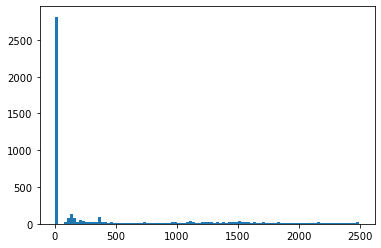

In [ ]:
n_bins = 100
x = toosmalldist
fig, ax = plt.subplots()
ax.hist(x, bins=n_bins)
plt.show()

In [ ]:
toosmalldist = []
for each in toosmall:
    if (each[1] < 2500) and (each[1] > 0):
        toosmalldist.append(each[1])

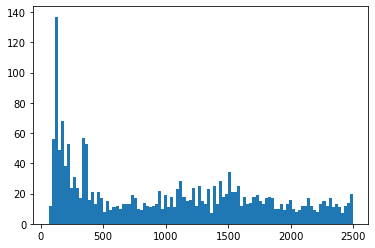

In [ ]:
n_bins = 100
x = toosmalldist
fig, ax = plt.subplots()
ax.hist(x, bins=n_bins)
plt.show()

There are a lot of documents with no actual article (length 0), we'll remove them.
Also, anything shorter than 2500 characters, which is likely around 500 words, probably will not contribute to helping the model learn meaningful summaries from longer form texts. So we'll remove 178+4746=4924 examples from the training set. This is roughly 5% of it. This is just a heuristic.
<br><br>
We also should check how many examples we have left do not have abstracts (in which case we won't have a ground truth)


In [ ]:
noabs= []
for i, each in enumerate(scientific_papers['train']):
    length = len(each['article'])
    if (length <= 100000) and (length >=2500):
        abstractlen = len(each['abstract'])
        if abstractlen == 0:
            noabs.append(i)


In [ ]:
len(noabs)

0

Nice, there are none.<br><br>
Now we can consolidate all the indices of examples we want to eliminate

In [ ]:
toobigidx = [each[0] for each in toobig]
toosmallidx = [each[0] for each in toosmall]
omit = toobigidx + toosmallidx

#pickle.dump(omit, open("omit.p", 'wb'))
#pickle.load(open("omit.p", 'rb'))

# Process Dataset

In [25]:
article = list(dict.fromkeys(nltk.sent_tokenize(scientific_papers['train'][11]['article'].replace('\n', ' '))))
abstract = nltk.sent_tokenize(scientific_papers['train'][11]['abstract'].replace('\n', ' '))
res = nallapati_method(article, abstract)

[]


IndexError: ignored

In [ ]:
seqlabel = [1 if i+1 in res[1] else 0 for i, each in enumerate(article)]

In [ ]:
np.array(seqlabel)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0])

In [ ]:
seqlabel

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0]

In [87]:
temp

<tf.Tensor: shape=(), dtype=string, numpy=b' backgroundarteriovenous malformations ( avms ) with vascular abnormalities , including aneurysms , have been reported frequently . however , the coexistence of avm and unilateral moyamoya disease is rare . \n we report herein an avm patient who presented with acute ischemic stroke with unilateral moyamoya disease and occlusion of the feeding artery.case reporta-41-year old man was admitted with sudden dysarthria and facial palsy . \n brain computed tomography and magnetic resonance imaging revealed an acute infarction adjacent to a large avm in the right frontal lobe . \n cerebral angiography revealed occlusions of the proximal right middle cerebral and proximal anterior cerebral arteries , which were the main feeders of the avm . \n innumerable telangiectatic moyamoya - type vessels between branches of the anterior cerebral artery and dilated lenticulostriate arteries on the occluded middle cerebral artery were detected . \n however , a nid

In [94]:
def tfunc (ex):
    abstract = str(example['abstract']).replace("\\n", ' ')
    abstract = nltk.sent_tokenize(abstract)
    return len(abstract)
scientific_papers.map(tfunc)
for each in scientific

<MapDataset shapes: {abstract: (), article: (), section_names: (), labels: ()}, types: {abstract: tf.string, article: tf.string, section_names: tf.string, labels: tf.string}>

In [93]:
for example in scientific_papers:
    abstract = str(example['abstract']).replace("\\n", ' ')
    abstract = nltk.sent_tokenize(abstract)
    len(abstract)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



KeyboardInterrupt: 

In [81]:
omit =sorted(pickle.load(open("omit.p", 'rb')))
model = SentenceTransformer('msmarco-distilroberta-base-v2')
for i, example in enumerate(scientific_papers):
    article = str(example['article']).replace("\\n", ' ')
    article = list(dict.fromkeys(nltk.sent_tokenize(article)))
    abstract = str(example['abstract']).replace("\\n", ' ')
    abstract = nltk.sent_tokenize(abstract)
    res = nallapati_method(article, abstract)
    tmp = {}
    for each in res[1]:
        print()
    print(abstract)
    tmp['labels'] = np.array([1 if i+1 in res[1] else 0 for i, each in enumerate(article)])
    tmp['embeddings'] = model.encode(article, convert_to_tensor=True)
    #print(tmp)
    if (i == 1):
        break

{'labels': array([0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0]), 'embeddings': tensor([[ 0.1350, -0.5246, -0.3444,  ...,  0.1921,  0.5139, -0.2309],
        [-0.0777,  0.1273,  0.9286,  ..., -1.2782,  0.1533, -0.2617],
        [-0.2679, -0.1546,  0.3678,  ..., -0.8857,  0.2250,  0.3842],
        ...,
        [-0.1486, -0.1448, -0.4844,  ..., -1.5481,  0.2807,  0.1335],
        [-0.0270,  0.1195,  0.3596,  ..., -0.9456,  0.2627, -0.5638],
        [-0.2507, -1.1492, -0.5785,  ...,  0.3962,  0.3665,  0.4034]])}
{'labels': array([1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0]), 'embeddings': tensor([[ 0.1462, -0.4946,  0.0585,  ..., -0.4066,  0.0273, -0.3808],
        [-0.5076,  0.2109, -0.4607,  ...,  0.1751,  0.5419, -0.2569],
        [-0.2040,  0.0766, -0.2606,

In [9]:
omit =sorted(pickle.load(open("omit.p", 'rb')))
model = SentenceTransformer('msmarco-distilroberta-base-v2')
def build_new_data(example, idx):
    global omit
    if idx == omit[0]:
        omit = omit[1:]
        return {}
    article = list(dict.fromkeys(nltk.sent_tokenize(example['article'].replace('\n', ' '))))
    abstract = nltk.sent_tokenize(example['abstract'].replace('\n', ' '))
    res = nallapati_method(article, abstract)
    example['labels'] = np.array([1 if i+1 in res[1] else 0 for i, each in enumerate(article)])
    example['embeddings'] = model.encode(article, convert_to_tensor=True)
    example['article_sents'] = article
    return example

updated_dataset = scientific_papers.map(build_new_data, with_indices=True)


100%|██████████| 305M/305M [00:12<00:00, 24.1MB/s]


Token indices sequence length is longer than the specified maximum sequence length for this model (719 > 512). Running this sequence through the model will result in indexing errors


KeyError: ignored

In [ ]:
!git config user.email "alexdayouzhuang@gmail.com" &&

In [14]:
!git add * && git commit -m "from drive"


*** Please tell me who you are.

Run

  git config --global user.email "you@example.com"
  git config --global user.name "Your Name"

to set your account's default identity.
Omit --global to set the identity only in this repository.

fatal: unable to auto-detect email address (got 'root@5fbf327c4495.(none)')


In [ ]:
len(scientific_papers['train'][202]['article'].replace('\n', ' '))/5

1352.8